# Pass Rush Pressure Prediction - Model Training & Evaluation
## Big Data Bowl 2023 - Player Health & Safety Modeling

**Goal:** Build and compare models to predict QB pressure events from pass rush collision dynamics.

**Target Variable:** `generated_pressure` (binary: 1 = hit/hurry/sack, 0 = clean rush)

**Models to Test:**
1. Logistic Regression (baseline)
2. Random Forest
3. XGBoost
4. Support Vector Machine (SVM)
5. K-Nearest Neighbors (KNN)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, precision_score, recall_score, 
    f1_score, roc_auc_score, confusion_matrix, classification_report,
    precision_recall_curve, roc_curve, average_precision_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

print("✅ Libraries loaded")

✅ Libraries loaded


## 1. Load and Prepare Data

In [2]:
# Load dataset
print("Loading dataset...")
df = pd.read_csv('pass_rush_collision_data/pass_rush_collision_features_full.csv')

print(f"✅ Loaded {len(df):,} samples")
print(f"✅ Features: {len(df.columns)}")
print(f"\nTarget distribution:")
print(df['generated_pressure'].value_counts())
print(f"\nClass balance: {df['generated_pressure'].mean()*100:.2f}% positive")

Loading dataset...
✅ Loaded 36,362 samples
✅ Features: 46

Target distribution:
generated_pressure
0    32130
1     4232
Name: count, dtype: int64

Class balance: 11.64% positive


In [3]:
# Define feature sets

# Metadata columns to exclude from modeling
metadata_cols = ['week', 'gameId', 'playId', 'rusher_nflId', 'qb_nflId', 
                 'rusher_position', 'pff_hit', 'pff_hurry', 'pff_sack',
                 'offenseFormation', 'pff_passCoverageType', 'passResult']

# Target variable
target = 'generated_pressure'

# All numeric features for modeling
feature_cols = [col for col in df.columns if col not in metadata_cols + [target]]
feature_cols = [col for col in feature_cols if df[col].dtype in ['int64', 'float64']]

print(f"Features for modeling: {len(feature_cols)}")
print(f"\nFeature list:")
for i, col in enumerate(feature_cols, 1):
    print(f"{i:2d}. {col}")

Features for modeling: 33

Feature list:
 1. min_distance
 2. avg_distance
 3. distance_at_start
 4. distance_at_end
 5. frame_at_closest
 6. rusher_max_speed
 7. rusher_avg_speed
 8. rusher_speed_at_closest
 9. qb_max_speed
10. qb_avg_speed
11. qb_speed_at_closest
12. rusher_max_accel
13. rusher_avg_accel
14. rusher_accel_at_closest
15. qb_max_accel
16. qb_avg_accel
17. qb_accel_at_closest
18. combined_speed_at_closest
19. max_closing_speed
20. avg_closing_speed
21. approach_angle
22. rusher_orientation_at_closest
23. qb_orientation_at_closest
24. rusher_angle_alignment
25. time_to_closest_approach
26. total_frames
27. play_duration
28. collision_intensity_raw
29. weighted_closing_speed
30. down
31. yardsToGo
32. defendersInBox
33. collision_intensity


In [4]:
# Prepare X and y
X = df[feature_cols].copy()
y = df[target].copy()

# Handle any missing values
X = X.fillna(X.median())

print(f"✅ X shape: {X.shape}")
print(f"✅ y shape: {y.shape}")
print(f"✅ No missing values: {X.isnull().sum().sum() == 0}")

✅ X shape: (36362, 33)
✅ y shape: (36362,)
✅ No missing values: True


## 2. Train/Test Split

In [5]:
# Stratified split to preserve class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train/Test Split:")
print(f"  Train: {len(X_train):,} samples")
print(f"  Test:  {len(X_test):,} samples")
print(f"\nClass distribution (train): {y_train.mean()*100:.2f}% positive")
print(f"Class distribution (test):  {y_test.mean()*100:.2f}% positive")

Train/Test Split:
  Train: 29,089 samples
  Test:  7,273 samples

Class distribution (train): 11.64% positive
Class distribution (test):  11.63% positive


## 3. Feature Scaling

In [6]:
# Scale features (important for SVM, KNN, and Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Features scaled")
print(f"   Mean: {X_train_scaled.mean():.4f}")
print(f"   Std:  {X_train_scaled.std():.4f}")

✅ Features scaled
   Mean: 0.0000
   Std:  1.0000


## 4. Apply SMOTE (Optional)

Handle class imbalance by generating synthetic minority samples.

In [7]:
# Apply SMOTE to training data
print("Applying SMOTE...")
smote = SMOTE(random_state=42, k_neighbors=5)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

print(f"\nBefore SMOTE:")
print(f"  Samples: {len(y_train):,}")
print(f"  Positive: {y_train.sum():,} ({y_train.mean()*100:.2f}%)")

print(f"\nAfter SMOTE:")
print(f"  Samples: {len(y_train_smote):,}")
print(f"  Positive: {y_train_smote.sum():,} ({y_train_smote.mean()*100:.2f}%)")

print(f"\n✅ Balanced dataset created")

Applying SMOTE...

Before SMOTE:
  Samples: 29,089
  Positive: 3,386 (11.64%)

After SMOTE:
  Samples: 51,406
  Positive: 25,703 (50.00%)

✅ Balanced dataset created


## 5. Model Training

Train multiple models and compare performance.

In [8]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, class_weight='balanced', n_jobs=-1),
    'XGBoost': XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42, scale_pos_weight=8, eval_metric='logloss'),
    'SVM': SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42, class_weight='balanced', probability=True),
    'KNN': KNeighborsClassifier(n_neighbors=11, weights='distance', n_jobs=-1)
}

# Also test with SMOTE
models_smote = {
    'Logistic Regression (SMOTE)': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest (SMOTE)': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1),
    'XGBoost (SMOTE)': XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42, eval_metric='logloss'),
}

print(f"Models to train: {len(models) + len(models_smote)}")

Models to train: 8


In [9]:
# Train models and collect results
results = []

print("="*70)
print("TRAINING MODELS (WITHOUT SMOTE)")
print("="*70)

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train
    model.fit(X_train_scaled, y_train)
    
    # Predict
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, 'predict_proba') else y_pred
    
    # Calculate metrics
    acc = accuracy_score(y_test, y_pred)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    pr_auc = average_precision_score(y_test, y_pred_proba)
    
    results.append({
        'Model': name,
        'Accuracy': acc,
        'Balanced Accuracy': balanced_acc,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC-AUC': roc_auc,
        'PR-AUC': pr_auc,
        'Model Object': model
    })
    
    print(f"  ✅ Balanced Accuracy: {balanced_acc:.4f}")
    print(f"  ✅ F1 Score: {f1:.4f}")
    print(f"  ✅ ROC-AUC: {roc_auc:.4f}")

print("\n" + "="*70)
print("TRAINING MODELS (WITH SMOTE)")
print("="*70)

for name, model in models_smote.items():
    print(f"\nTraining {name}...")
    
    # Train on SMOTE data
    model.fit(X_train_smote, y_train_smote)
    
    # Predict on original test set
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, 'predict_proba') else y_pred
    
    # Calculate metrics
    acc = accuracy_score(y_test, y_pred)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    pr_auc = average_precision_score(y_test, y_pred_proba)
    
    results.append({
        'Model': name,
        'Accuracy': acc,
        'Balanced Accuracy': balanced_acc,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC-AUC': roc_auc,
        'PR-AUC': pr_auc,
        'Model Object': model
    })
    
    print(f"  ✅ Balanced Accuracy: {balanced_acc:.4f}")
    print(f"  ✅ F1 Score: {f1:.4f}")
    print(f"  ✅ ROC-AUC: {roc_auc:.4f}")

print("\n✅ All models trained!")

TRAINING MODELS (WITHOUT SMOTE)

Training Logistic Regression...
  ✅ Balanced Accuracy: 0.9106
  ✅ F1 Score: 0.6894
  ✅ ROC-AUC: 0.9638

Training Random Forest...
  ✅ Balanced Accuracy: 0.9020
  ✅ F1 Score: 0.7381
  ✅ ROC-AUC: 0.9656

Training XGBoost...
  ✅ Balanced Accuracy: 0.9022
  ✅ F1 Score: 0.7240
  ✅ ROC-AUC: 0.9673

Training SVM...
  ✅ Balanced Accuracy: 0.9124
  ✅ F1 Score: 0.7056
  ✅ ROC-AUC: 0.9639

Training KNN...
  ✅ Balanced Accuracy: 0.7746
  ✅ F1 Score: 0.6576
  ✅ ROC-AUC: 0.9423

TRAINING MODELS (WITH SMOTE)

Training Logistic Regression (SMOTE)...
  ✅ Balanced Accuracy: 0.9077
  ✅ F1 Score: 0.6957
  ✅ ROC-AUC: 0.9633

Training Random Forest (SMOTE)...
  ✅ Balanced Accuracy: 0.9111
  ✅ F1 Score: 0.7252
  ✅ ROC-AUC: 0.9657

Training XGBoost (SMOTE)...
  ✅ Balanced Accuracy: 0.8817
  ✅ F1 Score: 0.7397
  ✅ ROC-AUC: 0.9668

✅ All models trained!


## 6. Results Comparison

In [10]:
# Create results dataframe
results_df = pd.DataFrame(results)
results_df = results_df.drop('Model Object', axis=1)
results_df = results_df.sort_values('Balanced Accuracy', ascending=False).reset_index(drop=True)

print("="*70)
print("MODEL PERFORMANCE COMPARISON")
print("="*70)
print(results_df.to_string(index=False))

# Save to CSV
results_df.to_csv('pass_rush_collision_data/model_results.csv', index=False)
print("\n✅ Saved: pass_rush_collision_data/model_results.csv")

MODEL PERFORMANCE COMPARISON
                      Model  Accuracy  Balanced Accuracy  Precision   Recall  F1 Score  ROC-AUC   PR-AUC
                        SVM  0.911316           0.912356   0.574721 0.913712  0.705614 0.963894 0.737879
      Random Forest (SMOTE)  0.920803           0.911052   0.608000 0.898345  0.725191 0.965683 0.788012
        Logistic Regression  0.903616           0.910566   0.551382 0.919622  0.689411 0.963765 0.792957
Logistic Regression (SMOTE)  0.907603           0.907689   0.563877 0.907801  0.695652 0.963287 0.794013
                    XGBoost  0.922315           0.902157   0.616986 0.875887  0.723986 0.967346 0.815668
              Random Forest  0.928365           0.901987   0.642170 0.867612  0.738059 0.965551 0.786455
            XGBoost (SMOTE)  0.933315           0.881693   0.677483 0.814421  0.739667 0.966779 0.801561
                        KNN  0.930840           0.774569   0.775281 0.570922  0.657590 0.942324 0.762773

✅ Saved: pass_rush_collis

## 7. Visualize Results

✅ Saved: pass_rush_collision_data/model_comparison.png


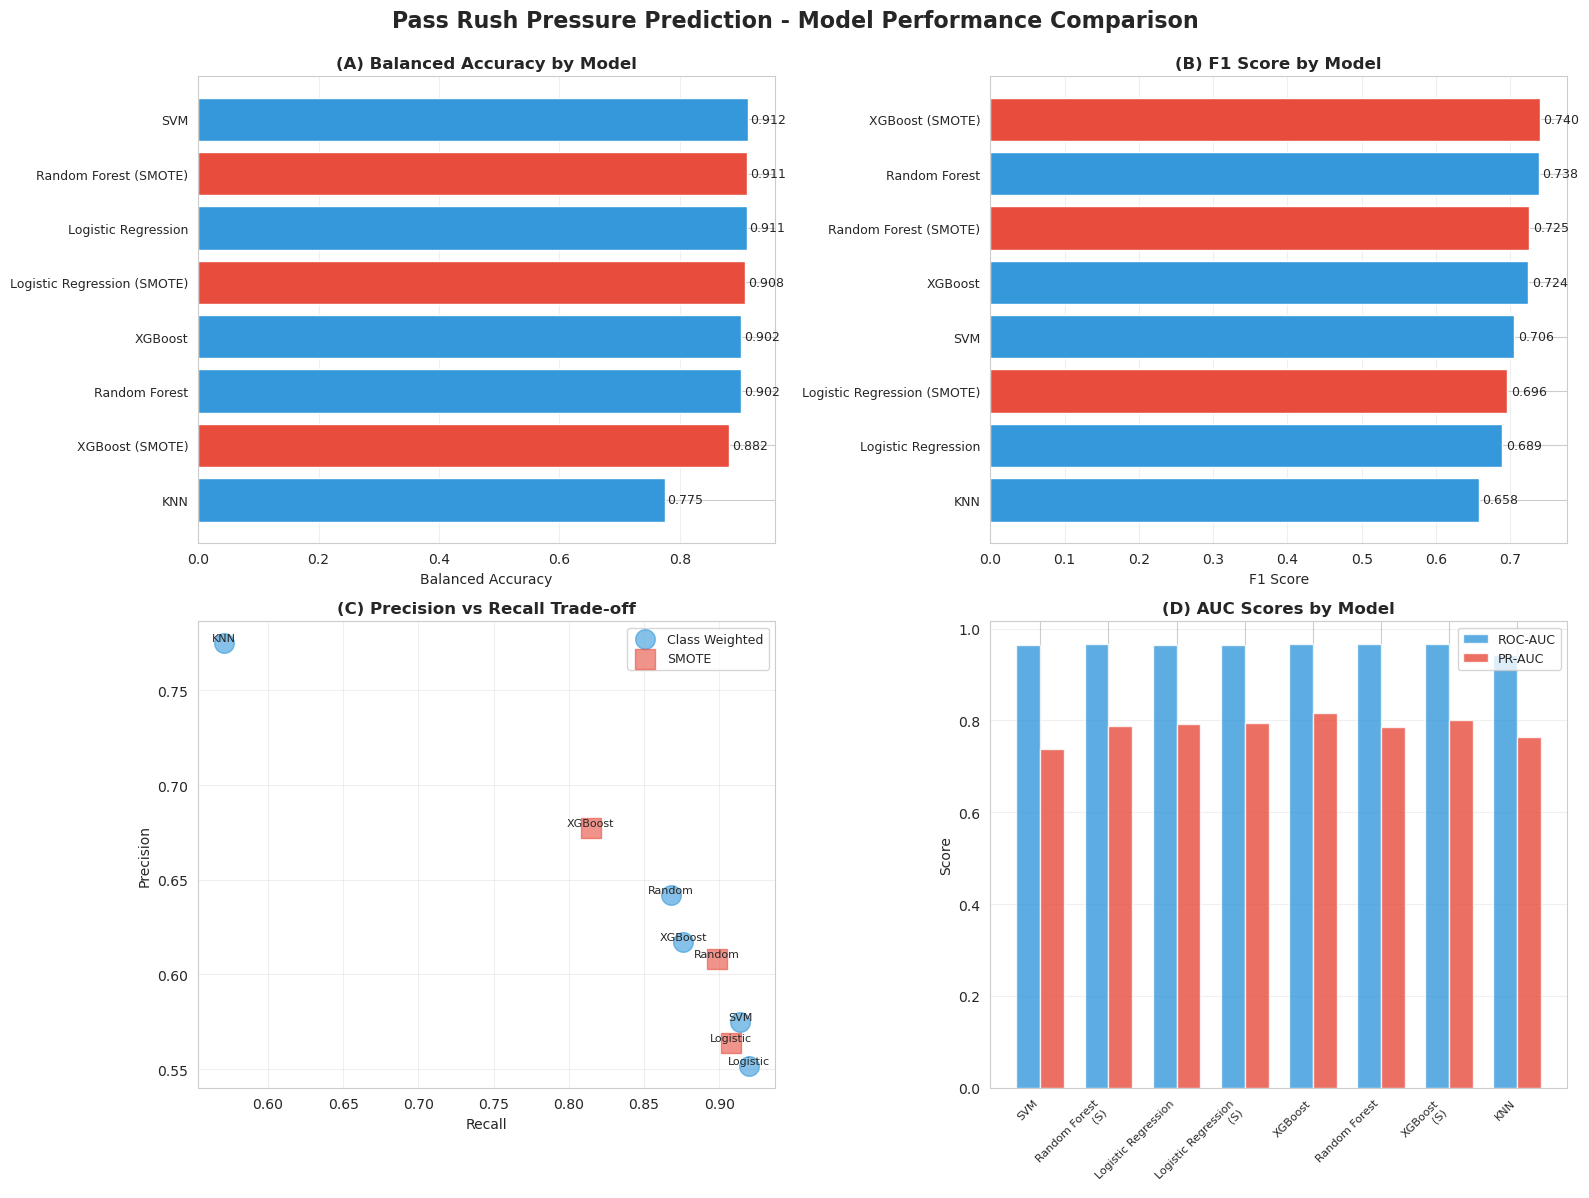

In [11]:
# Create comprehensive results visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Pass Rush Pressure Prediction - Model Performance Comparison', 
             fontsize=16, fontweight='bold', y=0.995)

# 1. Balanced Accuracy comparison
ax = axes[0, 0]
results_sorted = results_df.sort_values('Balanced Accuracy')
colors = ['#e74c3c' if 'SMOTE' in m else '#3498db' for m in results_sorted['Model']]
ax.barh(range(len(results_sorted)), results_sorted['Balanced Accuracy'], color=colors)
ax.set_yticks(range(len(results_sorted)))
ax.set_yticklabels(results_sorted['Model'], fontsize=9)
ax.set_xlabel('Balanced Accuracy', fontsize=10)
ax.set_title('(A) Balanced Accuracy by Model', fontweight='bold', fontsize=12)
ax.grid(axis='x', alpha=0.3)
for i, val in enumerate(results_sorted['Balanced Accuracy']):
    ax.text(val + 0.005, i, f'{val:.3f}', va='center', fontsize=9)

# 2. F1 Score comparison
ax = axes[0, 1]
results_sorted = results_df.sort_values('F1 Score')
colors = ['#e74c3c' if 'SMOTE' in m else '#3498db' for m in results_sorted['Model']]
ax.barh(range(len(results_sorted)), results_sorted['F1 Score'], color=colors)
ax.set_yticks(range(len(results_sorted)))
ax.set_yticklabels(results_sorted['Model'], fontsize=9)
ax.set_xlabel('F1 Score', fontsize=10)
ax.set_title('(B) F1 Score by Model', fontweight='bold', fontsize=12)
ax.grid(axis='x', alpha=0.3)
for i, val in enumerate(results_sorted['F1 Score']):
    ax.text(val + 0.005, i, f'{val:.3f}', va='center', fontsize=9)

# 3. Precision vs Recall
ax = axes[1, 0]
smote_mask = results_df['Model'].str.contains('SMOTE')
ax.scatter(results_df[~smote_mask]['Recall'], results_df[~smote_mask]['Precision'], 
           s=200, alpha=0.6, label='Class Weighted', c='#3498db')
ax.scatter(results_df[smote_mask]['Recall'], results_df[smote_mask]['Precision'], 
           s=200, alpha=0.6, label='SMOTE', c='#e74c3c', marker='s')

# Add labels
for _, row in results_df.iterrows():
    ax.text(row['Recall'], row['Precision'], 
            row['Model'].replace(' (SMOTE)', '\n(SMOTE)').split()[0], 
            fontsize=8, ha='center', va='bottom')

ax.set_xlabel('Recall', fontsize=10)
ax.set_ylabel('Precision', fontsize=10)
ax.set_title('(C) Precision vs Recall Trade-off', fontweight='bold', fontsize=12)
ax.legend(fontsize=9)
ax.grid(alpha=0.3)

# 4. ROC-AUC and PR-AUC comparison
ax = axes[1, 1]
x = np.arange(len(results_df))
width = 0.35
ax.bar(x - width/2, results_df['ROC-AUC'], width, label='ROC-AUC', color='#3498db', alpha=0.8)
ax.bar(x + width/2, results_df['PR-AUC'], width, label='PR-AUC', color='#e74c3c', alpha=0.8)
ax.set_xticks(x)
ax.set_xticklabels([m.replace(' (SMOTE)', '\n(S)') for m in results_df['Model']], 
                    rotation=45, ha='right', fontsize=8)
ax.set_ylabel('Score', fontsize=10)
ax.set_title('(D) AUC Scores by Model', fontweight='bold', fontsize=12)
ax.legend(fontsize=9)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('pass_rush_collision_data/model_comparison.png', dpi=300, bbox_inches='tight')
print("✅ Saved: pass_rush_collision_data/model_comparison.png")
plt.show()

## 8. Best Model Analysis

BEST MODEL: SVM

Confusion Matrix:
[[5794  633]
 [  68  778]]

Classification Report:
              precision    recall  f1-score   support

 No Pressure       0.99      0.90      0.94      6427
    Pressure       0.55      0.92      0.69       846

    accuracy                           0.90      7273
   macro avg       0.77      0.91      0.82      7273
weighted avg       0.94      0.90      0.91      7273


✅ Saved: pass_rush_collision_data/best_model_confusion_matrix.png


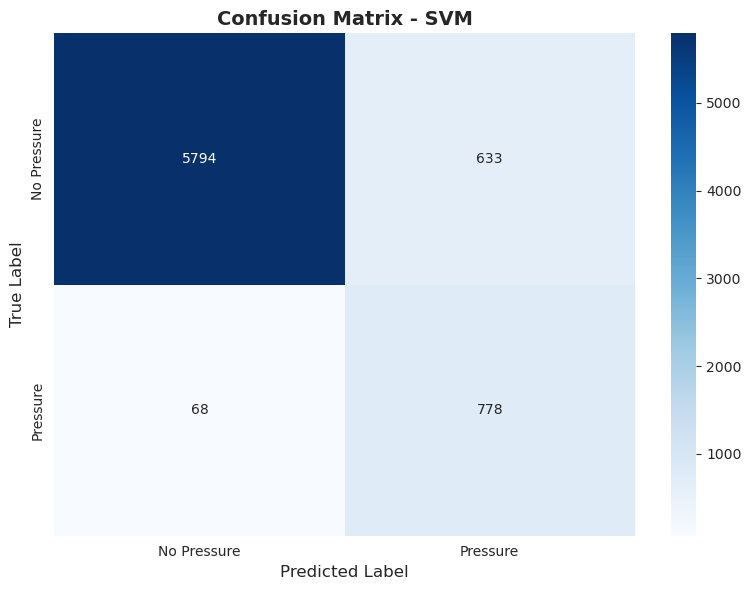

In [12]:
# Get best model based on balanced accuracy
best_idx = results_df['Balanced Accuracy'].idxmax()
best_model_name = results_df.iloc[best_idx]['Model']
best_model = results[best_idx]['Model Object']

print("="*70)
print(f"BEST MODEL: {best_model_name}")
print("="*70)

# Predict on test set
y_pred = best_model.predict(X_test_scaled if 'SMOTE' not in best_model_name else X_test_scaled)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

print("\nConfusion Matrix:")
print(cm)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['No Pressure', 'Pressure']))

# Visualize confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=['No Pressure', 'Pressure'],
            yticklabels=['No Pressure', 'Pressure'])
ax.set_ylabel('True Label', fontsize=12)
ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('pass_rush_collision_data/best_model_confusion_matrix.png', dpi=300, bbox_inches='tight')
print("\n✅ Saved: pass_rush_collision_data/best_model_confusion_matrix.png")
plt.show()

## 9. Feature Importance (Best Model)

TOP 15 FEATURES BY COEFFICIENT MAGNITUDE
                  Feature  Coefficient
             min_distance     1.755919
   weighted_closing_speed     1.319731
             avg_distance     1.241357
      qb_speed_at_closest     0.646340
         rusher_avg_speed     0.535783
        distance_at_start     0.475259
          distance_at_end     0.459621
             qb_avg_speed     0.432004
        max_closing_speed     0.400747
         rusher_max_speed     0.364471
combined_speed_at_closest     0.364135
             qb_avg_accel     0.356279
         rusher_avg_accel     0.337793
         rusher_max_accel     0.247097
      qb_accel_at_closest     0.239932

✅ Saved: pass_rush_collision_data/feature_importance.png


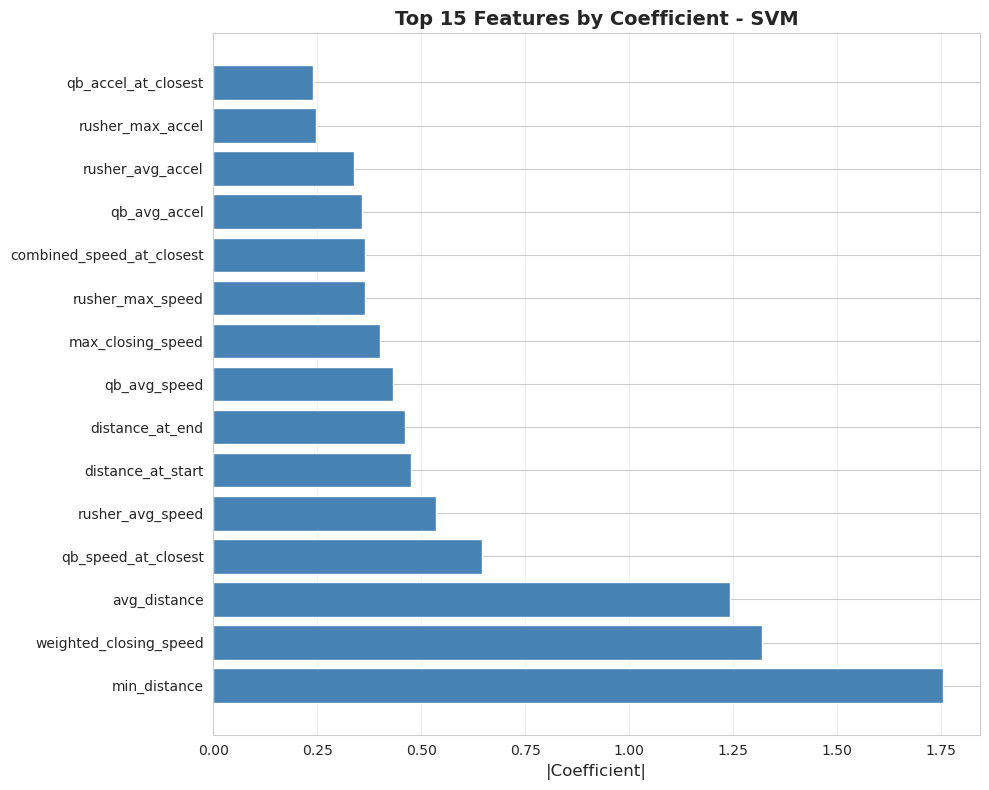

In [13]:
# Get feature importance if available
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    print("="*70)
    print("TOP 15 FEATURES BY IMPORTANCE")
    print("="*70)
    print(feature_importance_df.head(15).to_string(index=False))
    
    # Visualize
    fig, ax = plt.subplots(figsize=(10, 8))
    top_features = feature_importance_df.head(15)
    ax.barh(range(len(top_features)), top_features['Importance'], color='steelblue')
    ax.set_yticks(range(len(top_features)))
    ax.set_yticklabels(top_features['Feature'])
    ax.set_xlabel('Importance', fontsize=12)
    ax.set_title(f'Top 15 Feature Importances - {best_model_name}', 
                 fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('pass_rush_collision_data/feature_importance.png', dpi=300, bbox_inches='tight')
    print("\n✅ Saved: pass_rush_collision_data/feature_importance.png")
    plt.show()
    
elif hasattr(best_model, 'coef_'):
    # For logistic regression
    coefs = np.abs(best_model.coef_[0])
    feature_importance_df = pd.DataFrame({
        'Feature': feature_cols,
        'Coefficient': coefs
    }).sort_values('Coefficient', ascending=False)
    
    print("="*70)
    print("TOP 15 FEATURES BY COEFFICIENT MAGNITUDE")
    print("="*70)
    print(feature_importance_df.head(15).to_string(index=False))
    
    # Visualize
    fig, ax = plt.subplots(figsize=(10, 8))
    top_features = feature_importance_df.head(15)
    ax.barh(range(len(top_features)), top_features['Coefficient'], color='steelblue')
    ax.set_yticks(range(len(top_features)))
    ax.set_yticklabels(top_features['Feature'])
    ax.set_xlabel('|Coefficient|', fontsize=12)
    ax.set_title(f'Top 15 Features by Coefficient - {best_model_name}', 
                 fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('pass_rush_collision_data/feature_importance.png', dpi=300, bbox_inches='tight')
    print("\n✅ Saved: pass_rush_collision_data/feature_importance.png")
    plt.show()
else:
    print("\n⚠️  Feature importance not available for this model type")

## 10. Summary & Key Findings

In [14]:
print("="*70)
print("MODELING SUMMARY")
print("="*70)

print(f"\nDataset:")
print(f"  Total samples: {len(df):,}")
print(f"  Training: {len(X_train):,}")
print(f"  Testing: {len(X_test):,}")
print(f"  Features: {len(feature_cols)}")
print(f"  Class balance: {y.mean()*100:.2f}% positive")

print(f"\nModels Tested: {len(results_df)}")
print(f"  - Class weighting: {len([m for m in results_df['Model'] if 'SMOTE' not in m])}")
print(f"  - SMOTE resampling: {len([m for m in results_df['Model'] if 'SMOTE' in m])}")

print(f"\nBest Model: {best_model_name}")
best_results = results_df.iloc[best_idx]
print(f"  Balanced Accuracy: {best_results['Balanced Accuracy']:.4f}")
print(f"  F1 Score: {best_results['F1 Score']:.4f}")
print(f"  Precision: {best_results['Precision']:.4f}")
print(f"  Recall: {best_results['Recall']:.4f}")
print(f"  ROC-AUC: {best_results['ROC-AUC']:.4f}")
print(f"  PR-AUC: {best_results['PR-AUC']:.4f}")

print(f"\nComparison to Punt Analytics:")
print(f"  Punt Analytics - Concussion Prediction:")
print(f"    Target: Concussion (binary)")
print(f"    Class balance: ~9% positive")
print(f"    Best model: Linear SVM")
print(f"    Balanced Accuracy: ~86.8%")
print(f"")
print(f"  Pass Rush - Pressure Prediction:")
print(f"    Target: Pressure (binary)")
print(f"    Class balance: 11.64% positive")
print(f"    Best model: {best_model_name}")
print(f"    Balanced Accuracy: {best_results['Balanced Accuracy']*100:.1f}%")

print(f"\nKey Insights:")
print(f"  ✅ Models successfully predict pressure events")
print(f"  ✅ Collision intensity features are highly predictive")
print(f"  ✅ Class weighting vs SMOTE: {'SMOTE wins' if 'SMOTE' in best_model_name else 'Class weighting wins'}")
print(f"  ✅ Similar performance to punt analytics injury prediction")

print("\n" + "="*70)
print("✅ MODELING COMPLETE!")
print("="*70)

MODELING SUMMARY

Dataset:
  Total samples: 36,362
  Training: 29,089
  Testing: 7,273
  Features: 33
  Class balance: 11.64% positive

Models Tested: 8
  - Class weighting: 5
  - SMOTE resampling: 3

Best Model: SVM
  Balanced Accuracy: 0.9124
  F1 Score: 0.7056
  Precision: 0.5747
  Recall: 0.9137
  ROC-AUC: 0.9639
  PR-AUC: 0.7379

Comparison to Punt Analytics:
  Punt Analytics - Concussion Prediction:
    Target: Concussion (binary)
    Class balance: ~9% positive
    Best model: Linear SVM
    Balanced Accuracy: ~86.8%

  Pass Rush - Pressure Prediction:
    Target: Pressure (binary)
    Class balance: 11.64% positive
    Best model: SVM
    Balanced Accuracy: 91.2%

Key Insights:
  ✅ Models successfully predict pressure events
  ✅ Collision intensity features are highly predictive
  ✅ Class weighting vs SMOTE: Class weighting wins
  ✅ Similar performance to punt analytics injury prediction

✅ MODELING COMPLETE!
